# 🎯 Adidas Operating Profit Prediction - MLOps Pipeline

## Project Overview
This notebook builds an end-to-end AI system that predicts **Operating Profit** for Adidas sales data.

### Goals:
1. **Data Science Notebook** for EDA, preprocessing, and model training
2. **FastAPI backend** for real-time predictions  
3. **Streamlit dashboard** for executive interaction
4. **Dockerized environment** for consistent deployment

### Target Variable: Operating Profit
We'll predict the operating profit based on features like Product, Region, Sales Method, Price per Unit, and Units Sold.

## 1. Import Required Libraries

In [1]:
# Essential data manipulation and analysis libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine Learning libraries
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb

# Model persistence
import joblib
import os
from datetime import datetime

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")
print(f"📅 Analysis date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ All libraries imported successfully!
📅 Analysis date: 2025-10-05 15:59:10


## 2. Load and Inspect Raw Data

In [2]:
# Load the raw Adidas sales data
data_path = '../data/raw/adidas.csv'
df_raw = pd.read_csv(data_path)

print("🔍 Dataset Overview:")
print(f"📊 Shape: {df_raw.shape}")
print(f"📋 Columns: {list(df_raw.columns)}")
print("\n" + "="*50)

print("\n📈 First 5 rows:")
display(df_raw.head())

print("\n📊 Dataset Info:")
df_raw.info()

print("\n📈 Statistical Summary:")
display(df_raw.describe())

🔍 Dataset Overview:
📊 Shape: (9641, 12)
📋 Columns: ['Retailer', 'Retailer ID', 'Invoice Date', 'Region', 'State', 'City', 'Product', 'Price per Unit', 'Units Sold', 'Total Sales', 'Operating Profit', 'Sales Method']


📈 First 5 rows:


,Retailer,Retailer ID,Invoice Date,Region,State,City,Product,Price per Unit,Units Sold,Total Sales,Operating Profit,Sales Method
0,Walmart,1128299,6/17/2021,Southeast,Florida,Orlando,Women's Apparel,$103.00,218,"22,454.00","$1,257",Online
1,West Gear,1128299,7/16/2021,South,Louisiana,New Orleans,Women's Apparel,$103.00,163,"16,789.00",$806,Online
2,Sports Direct,1197831,8/25/2021,South,Alabama,Birmingham,Men's Street Footwear,$10.00,700,"7,000","$3,150",Outlet
3,Sports Direct,1197831,8/27/2021,South,Alabama,Birmingham,Women's Street Footwear,$15.00,575,"8,625","$3,881",Outlet
4,Sports Direct,1197831,8/21/2021,South,Alabama,Birmingham,Women's Street Footwear,$15.00,475,"7,125","$3,206",Outlet



📊 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9641 entries, 0 to 9640
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Retailer          9641 non-null   object
 1   Retailer ID       9641 non-null   int64 
 2   Invoice Date      9641 non-null   object
 3   Region            9641 non-null   object
 4   State             9641 non-null   object
 5   City              9641 non-null   object
 6   Product           9641 non-null   object
 7   Price per Unit    9639 non-null   object
 8   Units Sold        9641 non-null   object
 9   Total Sales       9641 non-null   object
 10  Operating Profit  9641 non-null   object
 11  Sales Method      9641 non-null   object
dtypes: int64(1), object(11)
memory usage: 904.0+ KB

📈 Statistical Summary:


,Retailer ID
count,9.641000e+03
mean,1.173851e+06
std,2.635869e+04
min,1.128299e+06
25%,1.185732e+06
50%,1.185732e+06
75%,1.185732e+06
max,1.197831e+06


In [3]:
# Check for missing values and data quality issues
print("🔍 Missing Values Analysis:")
missing_data = df_raw.isnull().sum()
print(missing_data[missing_data > 0])

print("\n🎯 Target Variable (Operating Profit) Analysis:")
print(f"Unique values sample: {df_raw['Operating Profit'].unique()[:10]}")

print("\n💰 Price per Unit Analysis:")
print(f"Unique values sample: {df_raw['Price per Unit'].unique()[:10]}")

print("\n🏪 Categorical Variables:")
categorical_columns = ['Region', 'Product', 'Sales Method']
for col in categorical_columns:
    print(f"\n{col}: {df_raw[col].nunique()} unique values")
    print(f"Values: {df_raw[col].unique()}")

🔍 Missing Values Analysis:
Price per Unit    2
dtype: int64

🎯 Target Variable (Operating Profit) Analysis:
Unique values sample: ['$1,257 ' '$806 ' '$3,150 ' '$3,881 ' '$3,206 ' '$2,494 ' '$2,700 '
 '$993 ' '$2,975 ' '$2,231 ']

💰 Price per Unit Analysis:
Unique values sample: ['$103.00 ' '$10.00 ' '$15.00 ' '$20.00 ' '$44.00 ' '$48.00 ' '$39.00 '
 '$46.00 ' '$47.00 ' '$40.00 ']

🏪 Categorical Variables:

Region: 5 unique values
Values: ['Southeast' 'South' 'Midwest' 'Northeast' 'West']

Product: 7 unique values
Values: ["Women's Apparel" "Men's Street Footwear" "Women's Street Footwear"
 "Men's Athletic Footwear" "Women's Athletic Footwear" "Men's Apparel"
 "Men's aparel"]

Sales Method: 3 unique values
Values: ['Online' 'Outlet' 'In-store']


## 3. Data Cleaning and Preprocessing

In [10]:
# Create a copy for cleaning
df = df_raw.copy()

def clean_currency_column(column):
    """Clean currency columns by removing $ and commas, then convert to float"""
    return column.str.replace('$', '', regex=False).str.replace(',', '', regex=False).str.replace(' ', '', regex=False).astype(float)

def clean_numeric_column(column):
    """Clean numeric columns by removing commas and converting to appropriate type"""
    return column.str.replace(',', '', regex=False).astype(float)

# Clean Price per Unit column
print("🧹 Cleaning 'Price per Unit' column...")
df['Price per Unit'] = clean_currency_column(df['Price per Unit'])

# Clean Operating Profit column (our target variable)
print("🧹 Cleaning 'Operating Profit' column...")
df['Operating Profit'] = clean_currency_column(df['Operating Profit'])

# Clean Total Sales column
print("🧹 Cleaning 'Total Sales' column...")
df['Total Sales'] = clean_numeric_column(df['Total Sales'])

# Clean Units Sold column
print("🧹 Cleaning 'Units Sold' column...")
df['Units Sold'] = clean_numeric_column(df['Units Sold'])

# Convert Invoice Date to datetime
print("🧹 Converting 'Invoice Date' to datetime...")
df['Invoice Date'] = pd.to_datetime(df['Invoice Date'])

# Extract additional date features
df['Year'] = df['Invoice Date'].dt.year
df['Month'] = df['Invoice Date'].dt.month
df['Quarter'] = df['Invoice Date'].dt.quarter

print("✅ Data cleaning completed!")
print(f"\n📊 Cleaned dataset shape: {df.shape}")
print("\n📈 Data types after cleaning:")
print(df.dtypes)

🧹 Cleaning 'Price per Unit' column...
🧹 Cleaning 'Operating Profit' column...
🧹 Cleaning 'Total Sales' column...
🧹 Cleaning 'Units Sold' column...
🧹 Converting 'Invoice Date' to datetime...
✅ Data cleaning completed!

📊 Cleaned dataset shape: (9641, 15)

📈 Data types after cleaning:
Retailer                    object
Retailer ID                  int64
Invoice Date        datetime64[ns]
Region                      object
State                       object
City                        object
Product                     object
Price per Unit             float64
Units Sold                 float64
Total Sales                float64
Operating Profit           float64
Sales Method                object
Year                         int32
Month                        int32
Quarter                      int32
dtype: object


In [15]:
# Check for any remaining missing values or outliers
print("🔍 Final data quality check:")
print(f"Missing values by column:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

# Drop rows with missing values
print(f"\n🧹 Dropping rows with missing values...")
df = df.dropna()
print(f"Dataset shape after dropping NaN: {df.shape}")

print("\n📊 Target variable (Operating Profit) statistics:")
print(df['Operating Profit'].describe())

# Check for negative operating profits
negative_profits = df[df['Operating Profit'] < 0]
print(f"\n⚠️ Records with negative operating profit: {len(negative_profits)}")

# Remove any rows with negative operating profit as they might be data entry errors
df = df[df['Operating Profit'] >= 0]
print(f"✅ Dataset after removing negative profits: {df.shape}")

# Save cleaned dataset
cleaned_data_path = '../data/processed/cleaned_adidas.csv'
df.to_csv(cleaned_data_path, index=False)
print(f"💾 Cleaned dataset saved to: {cleaned_data_path}")

# Final check
print(f"\n✅ Final dataset check:")
print(f"Shape: {df.shape}")
print(f"Missing values: {df.isnull().sum().sum()}")
print(f"Data types: {df.dtypes.value_counts()}")

🔍 Final data quality check:
Missing values by column:
Price per Unit    2
dtype: int64

🧹 Dropping rows with missing values...
Dataset shape after dropping NaN: (9639, 15)

📊 Target variable (Operating Profit) statistics:
count     9639.000000
mean      3428.555181
std       5392.077399
min          0.000000
25%        192.000000
50%        436.000000
75%       5200.000000
max      39000.000000
Name: Operating Profit, dtype: float64

⚠️ Records with negative operating profit: 0
✅ Dataset after removing negative profits: (9639, 15)
💾 Cleaned dataset saved to: ../data/processed/cleaned_adidas.csv

✅ Final dataset check:
Shape: (9639, 15)
Missing values: 0
Data types: object            6
float64           4
int32             3
int64             1
datetime64[ns]    1
Name: count, dtype: int64


## 4. Exploratory Data Analysis (EDA)

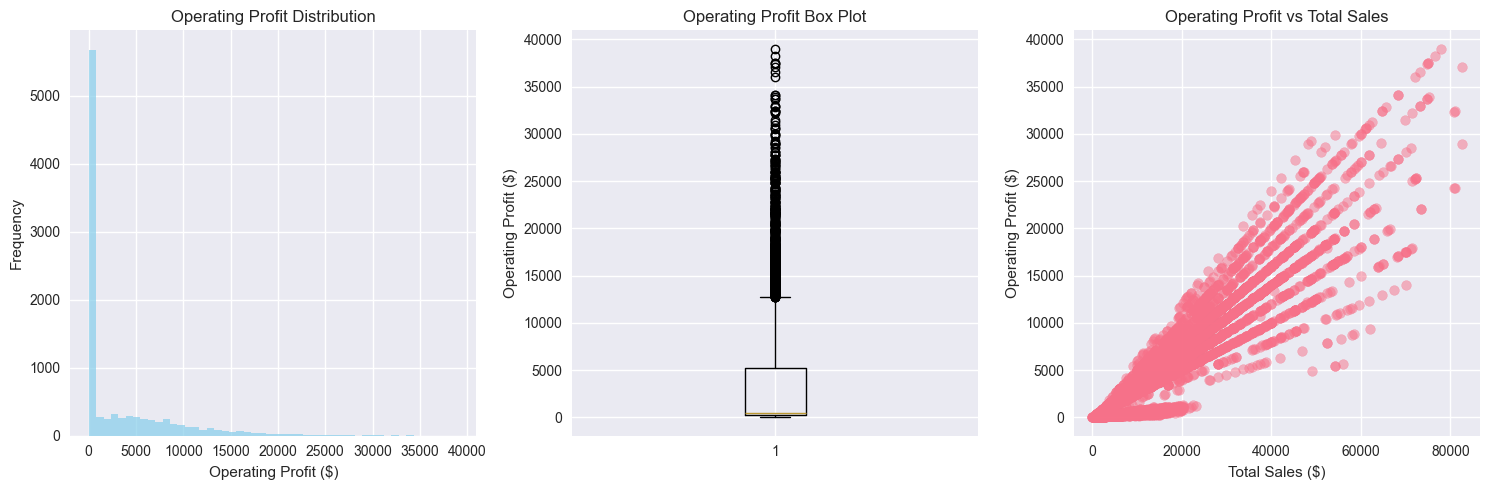

📊 Operating Profit Statistics:
Mean: $3430.05
Median: $437.00
Std: $5392.94
Min: $0.00
Max: $39000.00


In [6]:
# Distribution of target variable (Operating Profit)
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(df['Operating Profit'], bins=50, alpha=0.7, color='skyblue')
plt.title('Operating Profit Distribution')
plt.xlabel('Operating Profit ($)')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.boxplot(df['Operating Profit'])
plt.title('Operating Profit Box Plot')
plt.ylabel('Operating Profit ($)')

plt.subplot(1, 3, 3)
plt.scatter(df['Total Sales'], df['Operating Profit'], alpha=0.5)
plt.title('Operating Profit vs Total Sales')
plt.xlabel('Total Sales ($)')
plt.ylabel('Operating Profit ($)')

plt.tight_layout()
plt.show()

print(f"📊 Operating Profit Statistics:")
print(f"Mean: ${df['Operating Profit'].mean():.2f}")
print(f"Median: ${df['Operating Profit'].median():.2f}")
print(f"Std: ${df['Operating Profit'].std():.2f}")
print(f"Min: ${df['Operating Profit'].min():.2f}")
print(f"Max: ${df['Operating Profit'].max():.2f}")

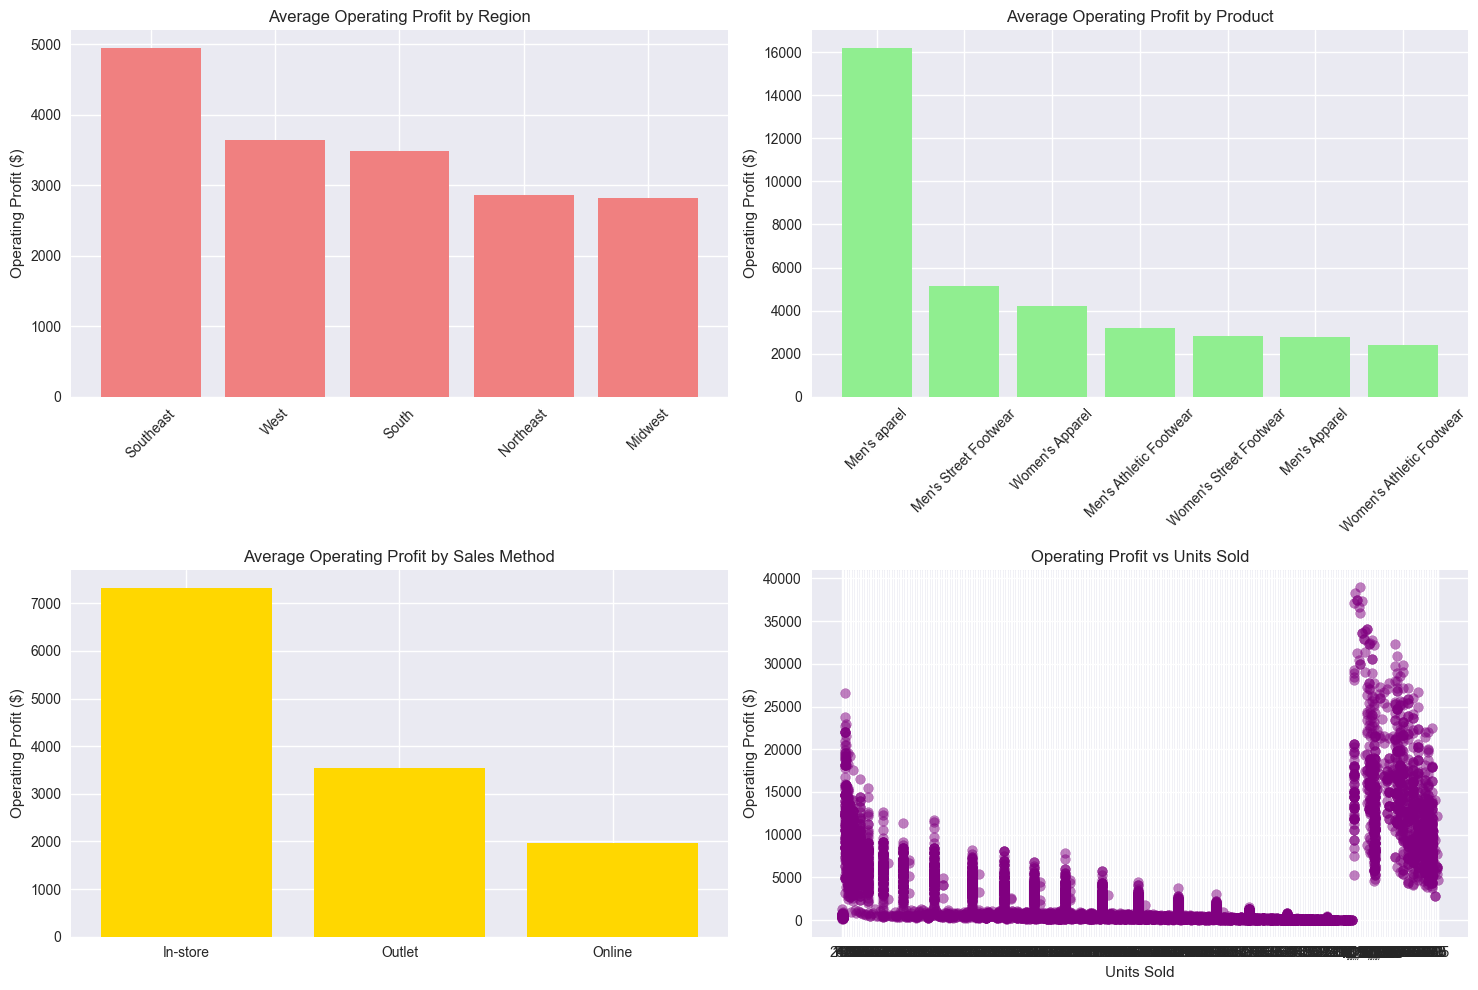

In [7]:
# Categorical variables analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Operating Profit by Region
region_profit = df.groupby('Region')['Operating Profit'].mean().sort_values(ascending=False)
axes[0, 0].bar(region_profit.index, region_profit.values, color='lightcoral')
axes[0, 0].set_title('Average Operating Profit by Region')
axes[0, 0].set_ylabel('Operating Profit ($)')
axes[0, 0].tick_params(axis='x', rotation=45)

# Operating Profit by Product
product_profit = df.groupby('Product')['Operating Profit'].mean().sort_values(ascending=False)
axes[0, 1].bar(product_profit.index, product_profit.values, color='lightgreen')
axes[0, 1].set_title('Average Operating Profit by Product')
axes[0, 1].set_ylabel('Operating Profit ($)')
axes[0, 1].tick_params(axis='x', rotation=45)

# Operating Profit by Sales Method
sales_method_profit = df.groupby('Sales Method')['Operating Profit'].mean().sort_values(ascending=False)
axes[1, 0].bar(sales_method_profit.index, sales_method_profit.values, color='gold')
axes[1, 0].set_title('Average Operating Profit by Sales Method')
axes[1, 0].set_ylabel('Operating Profit ($)')

# Units Sold vs Operating Profit
axes[1, 1].scatter(df['Units Sold'], df['Operating Profit'], alpha=0.5, color='purple')
axes[1, 1].set_title('Operating Profit vs Units Sold')
axes[1, 1].set_xlabel('Units Sold')
axes[1, 1].set_ylabel('Operating Profit ($)')

plt.tight_layout()
plt.show()

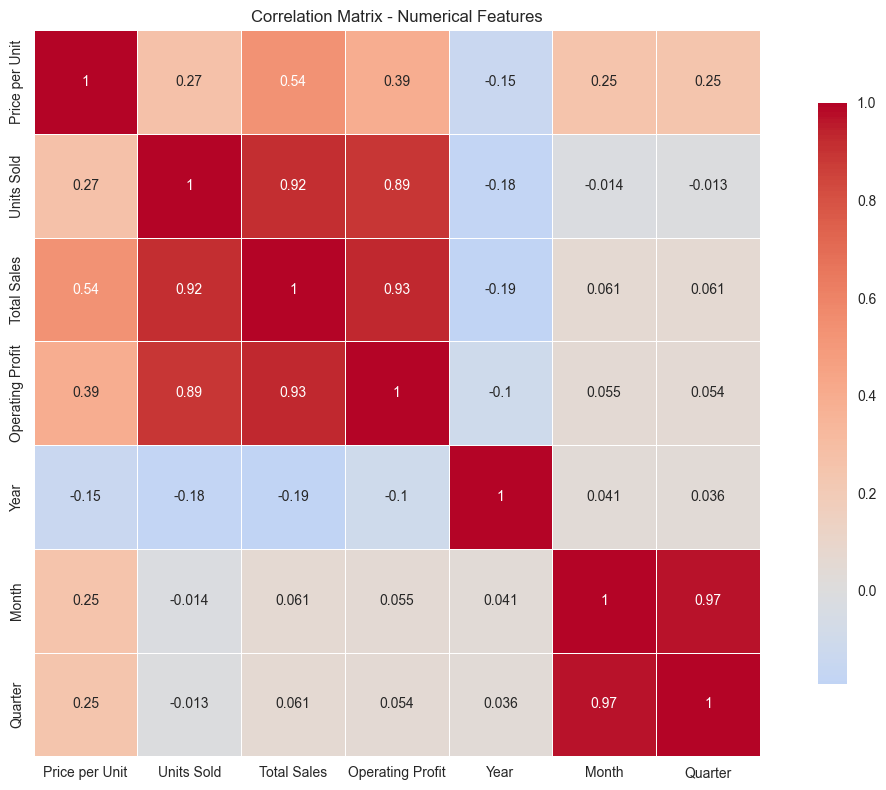

🔍 Key Correlations with Operating Profit:
Total Sales: 0.930
Units Sold: 0.894
Price per Unit: 0.394
Year: 0.104
Month: 0.055
Quarter: 0.054


In [11]:
# Correlation analysis
plt.figure(figsize=(12, 8))

# Select numeric columns for correlation
numeric_columns = ['Price per Unit', 'Units Sold', 'Total Sales', 'Operating Profit', 'Year', 'Month', 'Quarter']
correlation_matrix = df[numeric_columns].corr()

# Create heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix - Numerical Features')
plt.tight_layout()
plt.show()

print("🔍 Key Correlations with Operating Profit:")
profit_correlations = correlation_matrix['Operating Profit'].abs().sort_values(ascending=False)
for feature, correlation in profit_correlations.items():
    if feature != 'Operating Profit':
        print(f"{feature}: {correlation:.3f}")

## 5. Feature Engineering and Encoding

In [18]:
# Prepare features for machine learning
df_ml = df.copy()

# Create derived features
df_ml['Profit_Margin'] = df_ml['Operating Profit'] / df_ml['Total Sales']
df_ml['Revenue_per_Unit'] = df_ml['Total Sales'] / df_ml['Units Sold']

# Handle any infinite values that might have been created
df_ml = df_ml.replace([np.inf, -np.inf], np.nan)
df_ml = df_ml.dropna()

print(f"📊 Dataset shape after handling infinite values: {df_ml.shape}")

# Initialize label encoders for categorical variables
label_encoders = {}
categorical_features = ['Region', 'Product', 'Sales Method']

print("🔧 Encoding categorical features:")
for feature in categorical_features:
    le = LabelEncoder()
    df_ml[f'{feature}_encoded'] = le.fit_transform(df_ml[feature])
    label_encoders[feature] = le
    print(f"✅ {feature}: {len(le.classes_)} unique categories")
    print(f"   Categories: {list(le.classes_)}")
    print()

# Select features for the model
feature_columns = [
    'Price per Unit', 'Units Sold', 'Year', 'Month', 'Quarter',
    'Region_encoded', 'Product_encoded', 'Sales Method_encoded',
    'Profit_Margin', 'Revenue_per_Unit'
]

X = df_ml[feature_columns]
y = df_ml['Operating Profit']

# Final check for NaN values
print(f"📊 Feature matrix shape: {X.shape}")
print(f"🎯 Target variable shape: {y.shape}")
print(f"🔍 NaN values in features: {X.isnull().sum().sum()}")
print(f"🔍 Infinite values in features: {np.isinf(X).sum().sum()}")
print(f"\n📋 Selected features: {feature_columns}")

# Save label encoders for later use in API
encoders_path = '../models/'
os.makedirs(encoders_path, exist_ok=True)
joblib.dump(label_encoders, f'{encoders_path}label_encoders.joblib')
print(f"\n💾 Label encoders saved to: {encoders_path}label_encoders.joblib")

📊 Dataset shape after handling infinite values: (9635, 17)
🔧 Encoding categorical features:
✅ Region: 5 unique categories
   Categories: ['Midwest', 'Northeast', 'South', 'Southeast', 'West']

✅ Product: 7 unique categories
   Categories: ["Men's Apparel", "Men's Athletic Footwear", "Men's Street Footwear", "Men's aparel", "Women's Apparel", "Women's Athletic Footwear", "Women's Street Footwear"]

✅ Sales Method: 3 unique categories
   Categories: ['In-store', 'Online', 'Outlet']

📊 Feature matrix shape: (9635, 10)
🎯 Target variable shape: (9635,)
🔍 NaN values in features: 0
🔍 Infinite values in features: 0

📋 Selected features: ['Price per Unit', 'Units Sold', 'Year', 'Month', 'Quarter', 'Region_encoded', 'Product_encoded', 'Sales Method_encoded', 'Profit_Margin', 'Revenue_per_Unit']

💾 Label encoders saved to: ../models/label_encoders.joblib


## 6. Model Training and Selection

In [19]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"📊 Training set shape: {X_train.shape}")
print(f"📊 Testing set shape: {X_test.shape}")

# Initialize models
models = {
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(random_state=42)
}

# Train and evaluate models
model_results = {}

print("🚀 Training models...")
print("="*50)

for name, model in models.items():
    print(f"\n🔧 Training {name}...")
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Calculate metrics
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    
    # Store results
    model_results[name] = {
        'model': model,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse
    }
    
    print(f"✅ {name} Results:")
    print(f"   Training R²: {train_r2:.4f}")
    print(f"   Testing R²: {test_r2:.4f}")
    print(f"   Training MAE: ${train_mae:.2f}")
    print(f"   Testing MAE: ${test_mae:.2f}")
    print(f"   Training RMSE: ${train_rmse:.2f}")
    print(f"   Testing RMSE: ${test_rmse:.2f}")

print("\n🏆 Model Comparison Summary:")
print("="*50)
for name, results in model_results.items():
    print(f"{name}: Test R² = {results['test_r2']:.4f}, Test MAE = ${results['test_mae']:.2f}")

📊 Training set shape: (7708, 10)
📊 Testing set shape: (1927, 10)
🚀 Training models...

🔧 Training Random Forest...
✅ Random Forest Results:
   Training R²: 0.9994
   Testing R²: 0.9955
   Training MAE: $42.19
   Testing MAE: $117.24
   Training RMSE: $132.65
   Testing RMSE: $358.70

🔧 Training XGBoost...
✅ XGBoost Results:
   Training R²: 0.9998
   Testing R²: 0.9976
   Training MAE: $45.69
   Testing MAE: $105.33
   Training RMSE: $85.01
   Testing RMSE: $259.78

🏆 Model Comparison Summary:
Random Forest: Test R² = 0.9955, Test MAE = $117.24
XGBoost: Test R² = 0.9976, Test MAE = $105.33
✅ Random Forest Results:
   Training R²: 0.9994
   Testing R²: 0.9955
   Training MAE: $42.19
   Testing MAE: $117.24
   Training RMSE: $132.65
   Testing RMSE: $358.70

🔧 Training XGBoost...
✅ XGBoost Results:
   Training R²: 0.9998
   Testing R²: 0.9976
   Training MAE: $45.69
   Testing MAE: $105.33
   Training RMSE: $85.01
   Testing RMSE: $259.78

🏆 Model Comparison Summary:
Random Forest: Test R

In [20]:
# Hyperparameter tuning for the best performing model
# Select the best model based on test R² score
best_model_name = max(model_results.keys(), key=lambda k: model_results[k]['test_r2'])
print(f"🏆 Best performing model: {best_model_name}")

# Hyperparameter tuning for Random Forest (assuming it's the best)
if best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    
    print("🔧 Performing hyperparameter tuning for Random Forest...")
    grid_search = GridSearchCV(
        RandomForestRegressor(random_state=42),
        param_grid,
        cv=5,
        scoring='r2',
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train, y_train)
    
    # Get the best model
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    print(f"✅ Best parameters: {best_params}")
    print(f"✅ Best CV score: {grid_search.best_score_:.4f}")

elif best_model_name == 'XGBoost':
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 6, 10],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 0.9, 1.0]
    }
    
    print("🔧 Performing hyperparameter tuning for XGBoost...")
    grid_search = GridSearchCV(
        xgb.XGBRegressor(random_state=42),
        param_grid,
        cv=5,
        scoring='r2',
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train, y_train)
    
    # Get the best model
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    print(f"✅ Best parameters: {best_params}")
    print(f"✅ Best CV score: {grid_search.best_score_:.4f}")

else:
    # Use the original best model if no tuning is performed
    best_model = model_results[best_model_name]['model']
    best_params = "Default parameters"

print(f"\n🎯 Final selected model: {best_model_name}")
print(f"📋 Model parameters: {best_params}")

🏆 Best performing model: XGBoost
🔧 Performing hyperparameter tuning for XGBoost...
Fitting 5 folds for each of 81 candidates, totalling 405 fits
✅ Best parameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300, 'subsample': 0.8}
✅ Best CV score: 0.9979

🎯 Final selected model: XGBoost
📋 Model parameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300, 'subsample': 0.8}
✅ Best parameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300, 'subsample': 0.8}
✅ Best CV score: 0.9979

🎯 Final selected model: XGBoost
📋 Model parameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300, 'subsample': 0.8}


## 7. Model Evaluation and Metrics

🎯 FINAL MODEL PERFORMANCE:
📊 Model: XGBoost
📈 R² Score: 0.9984
💰 Mean Absolute Error: $77.49
📏 Root Mean Square Error: $216.68

🔍 TOP 5 MOST IMPORTANT FEATURES:
1. Units Sold: 0.7574
2. Profit_Margin: 0.1613
3. Price per Unit: 0.0754
4. Year: 0.0016
5. Product_encoded: 0.0013


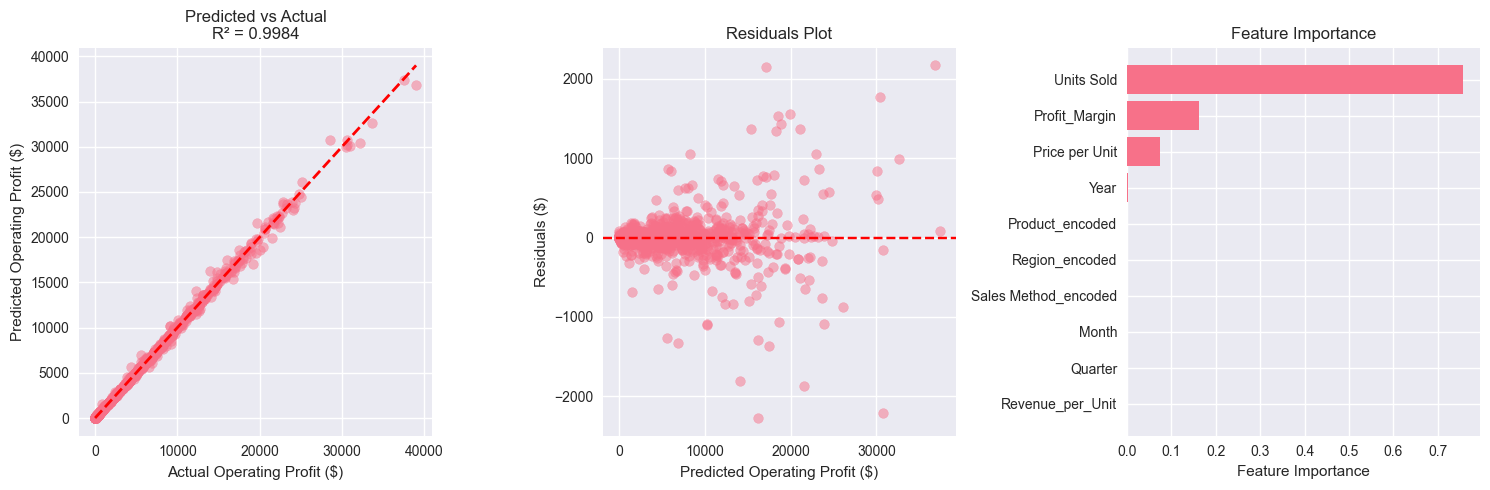

In [21]:
# Final model evaluation
y_pred_final = best_model.predict(X_test)

# Calculate final metrics
final_r2 = r2_score(y_test, y_pred_final)
final_mae = mean_absolute_error(y_test, y_pred_final)
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred_final))

print("🎯 FINAL MODEL PERFORMANCE:")
print("="*40)
print(f"📊 Model: {best_model_name}")
print(f"📈 R² Score: {final_r2:.4f}")
print(f"💰 Mean Absolute Error: ${final_mae:.2f}")
print(f"📏 Root Mean Square Error: ${final_rmse:.2f}")

# Prediction vs Actual plot
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(y_test, y_pred_final, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Operating Profit ($)')
plt.ylabel('Predicted Operating Profit ($)')
plt.title(f'Predicted vs Actual\nR² = {final_r2:.4f}')

# Residuals plot
plt.subplot(1, 3, 2)
residuals = y_test - y_pred_final
plt.scatter(y_pred_final, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Operating Profit ($)')
plt.ylabel('Residuals ($)')
plt.title('Residuals Plot')

# Feature importance (if Random Forest or tree-based model)
plt.subplot(1, 3, 3)
if hasattr(best_model, 'feature_importances_'):
    importance_df = pd.DataFrame({
        'feature': feature_columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.barh(range(len(importance_df)), importance_df['importance'])
    plt.yticks(range(len(importance_df)), importance_df['feature'])
    plt.xlabel('Feature Importance')
    plt.title('Feature Importance')
    plt.gca().invert_yaxis()
    
    print(f"\n🔍 TOP 5 MOST IMPORTANT FEATURES:")
    for i, (feature, importance) in enumerate(importance_df.head().values):
        print(f"{i+1}. {feature}: {importance:.4f}")

plt.tight_layout()
plt.show()

In [22]:
# Cross-validation for model stability
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='r2')

print("🔄 CROSS-VALIDATION RESULTS:")
print("="*35)
print(f"📊 CV Scores: {cv_scores}")
print(f"📈 Mean CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Model performance by categories
print("\n📊 PERFORMANCE BY CATEGORIES:")
print("="*35)

# Create test predictions DataFrame
test_results = X_test.copy()
test_results['Actual_Profit'] = y_test
test_results['Predicted_Profit'] = y_pred_final
test_results['Absolute_Error'] = np.abs(y_test - y_pred_final)

# Merge back categorical information for analysis
test_indices = test_results.index
test_categories = df_ml.loc[test_indices, ['Region', 'Product', 'Sales Method']]
test_results = pd.concat([test_results, test_categories], axis=1)

# Performance by Region
region_performance = test_results.groupby('Region').agg({
    'Absolute_Error': 'mean',
    'Actual_Profit': 'count'
}).round(2)
region_performance.columns = ['Mean_Absolute_Error', 'Count']
print(f"\n🌍 Performance by Region:")
print(region_performance)

# Performance by Product
product_performance = test_results.groupby('Product').agg({
    'Absolute_Error': 'mean',
    'Actual_Profit': 'count'
}).round(2)
product_performance.columns = ['Mean_Absolute_Error', 'Count']
print(f"\n👟 Performance by Product:")
print(product_performance)

# Performance by Sales Method
sales_performance = test_results.groupby('Sales Method').agg({
    'Absolute_Error': 'mean',
    'Actual_Profit': 'count'
}).round(2)
sales_performance.columns = ['Mean_Absolute_Error', 'Count']
print(f"\n🛒 Performance by Sales Method:")
print(sales_performance)

🔄 CROSS-VALIDATION RESULTS:
📊 CV Scores: [0.99853135 0.99793772 0.9979149  0.99635177 0.99857569]
📈 Mean CV Score: 0.9979 (+/- 0.0016)

📊 PERFORMANCE BY CATEGORIES:

🌍 Performance by Region:
           Mean_Absolute_Error  Count
Region                               
Midwest                  57.49    379
Northeast                53.99    497
South                   124.26    349
Southeast                96.68    244
West                     73.68    458

👟 Performance by Product:
                           Mean_Absolute_Error  Count
Product                                              
Men's Apparel                            68.85    295
Men's Athletic Footwear                  75.36    308
Men's Street Footwear                   112.90    339
Women's Apparel                          92.11    342
Women's Athletic Footwear                42.72    321
Women's Street Footwear                  69.31    322

🛒 Performance by Sales Method:
              Mean_Absolute_Error  Count
Sales Metho

## 8. Save Trained Model and Metadata

In [ ]:
# Save the trained model
model_path = '../models/model.joblib'
joblib.dump(best_model, model_path)
print(f"💾 Model saved to: {model_path}")

# Create and save model metadata
model_metadata = {
    'model_type': best_model_name,
    'model_params': best_params if 'best_params' in locals() else 'Default parameters',
    'performance_metrics': {
        'r2_score': final_r2,
        'mean_absolute_error': final_mae,
        'root_mean_square_error': final_rmse,
        'cv_score_mean': cv_scores.mean(),
        'cv_score_std': cv_scores.std()
    },
    'feature_columns': feature_columns,
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'training_data_shape': df.shape,
    'categorical_encodings': {
        feature: list(label_encoders[feature].classes_) 
        for feature in categorical_features
    }
}

# Save metadata
metadata_path = '../models/model_metadata.joblib'
joblib.dump(model_metadata, metadata_path)
print(f"📋 Model metadata saved to: {metadata_path}")

print("\n🎉 MODEL TRAINING COMPLETED SUCCESSFULLY!")
print("="*50)
print(f"✅ Model: {best_model_name}")
print(f"✅ R² Score: {final_r2:.4f}")
print(f"✅ MAE: ${final_mae:.2f}")
print(f"✅ RMSE: ${final_rmse:.2f}")
print(f"✅ Files saved:")
print(f"   - Model: {model_path}")
print(f"   - Metadata: {metadata_path}")
print(f"   - Encoders: {encoders_path}label_encoders.joblib")
print(f"   - Cleaned data: {cleaned_data_path}")

print(f"\n🚀 READY FOR DEPLOYMENT!")
print("The model is now ready to be used in the FastAPI backend and Streamlit dashboard.")

💾 Model saved to: ../models/model.joblib
📋 Model metadata saved to: ../models/model_metadata.joblib

🎉 MODEL TRAINING COMPLETED SUCCESSFULLY!
✅ Model: XGBoost
✅ R² Score: 0.9984
✅ MAE: $77.49
✅ RMSE: $216.68
✅ Files saved:
   - Model: ../models/model.joblib
   - Metadata: ../models/model_metadata.joblib
   - Encoders: ../models/label_encoders.joblib
   - Cleaned data: ../data/processed/cleaned_adidas.csv

🚀 READY FOR DEPLOYMENT!
The model is now ready to be used in the FastAPI backend and Streamlit dashboard.


: 

## 9. API Testing - Real-time Predictions

In [ ]:
# Test the API with a simple call
import requests
import json

# API Configuration
API_URL = "http://localhost:8000"

def test_api_from_notebook():
    """Test the API from Jupyter notebook"""
    
    # Test data
    test_data = {
        "product": "Men's Apparel",
        "region": "West", 
        "sales_method": "Online",
        "retailer": "Walmart",
        "price_per_unit": 80.0,
        "units_sold": 200
    }
    
    print("🚀 Testing API from Jupyter Notebook")
    print("=" * 50)
    
    try:
        # Test prediction endpoint
        print(f"📊 Input: {test_data}")
        response = requests.post(f"{API_URL}/predict", json=test_data)
        
        if response.status_code == 200:
            result = response.json()
            print("✅ API Call Successful!")
            print(f"💰 Predicted Profit: ${result['predicted_profit']:,.2f}")
            print(f"💵 Total Sales: ${result['total_sales']:,.2f}")
            print(f"🤖 Model Used: {result['model_used']}")
        else:
            print(f"❌ API Call Failed: {response.status_code}")
    
    except requests.exceptions.ConnectionError:
        print("❌ Cannot connect to API. Start it with: python API/main.py")
    except Exception as e:
        print(f"❌ Error: {e}")

# Run the test
test_api_from_notebook()